In [1]:
from dictionary_learning import CrossCoder
from nnsight import LanguageModel
import torch as th

In [2]:
from huggingface_hub import login
login("test")


In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
crosscoder = CrossCoder.from_pretrained("Butanium/gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", from_hub=True)
gemma_2 = LanguageModel("google/gemma-2-2b", device_map="cuda")
gemma_2_it = LanguageModel("google/gemma-2-2b-it", device_map="cuda")


Processing jokes:  10%|█         | 51/500 [03:04<40:31,  5.41s/it]

Processed 50 jokes. Latest non-zero count: 104


Processing jokes:  20%|██        | 101/500 [06:31<31:08,  4.68s/it] 

Processed 100 jokes. Latest non-zero count: 152


Processing jokes:  30%|███       | 151/500 [09:55<16:26,  2.83s/it]

Processed 150 jokes. Latest non-zero count: 152


Processing jokes:  40%|████      | 201/500 [12:21<12:33,  2.52s/it]

Processed 200 jokes. Latest non-zero count: 93


Processing jokes:  50%|█████     | 251/500 [15:09<19:15,  4.64s/it]

Processed 250 jokes. Latest non-zero count: 136


Processing jokes:  60%|██████    | 301/500 [17:28<07:01,  2.12s/it]

Processed 300 jokes. Latest non-zero count: 135


Processing jokes:  70%|███████   | 351/500 [18:34<02:58,  1.19s/it]

Processed 350 jokes. Latest non-zero count: 174


Processing jokes:  80%|████████  | 401/500 [19:40<01:32,  1.07it/s]

Processed 400 jokes. Latest non-zero count: 103


Processing jokes:  90%|█████████ | 451/500 [20:43<00:52,  1.07s/it]

Processed 450 jokes. Latest non-zero count: 137


Processing jokes: 100%|██████████| 500/500 [21:50<00:00,  2.62s/it]


Average non-zero elements per joke: 122.01
Min non-zero elements: 60
Max non-zero elements: 193
Number of unique feature indices activated across all jokes: 12240
Percentage of total features used: 16.60%


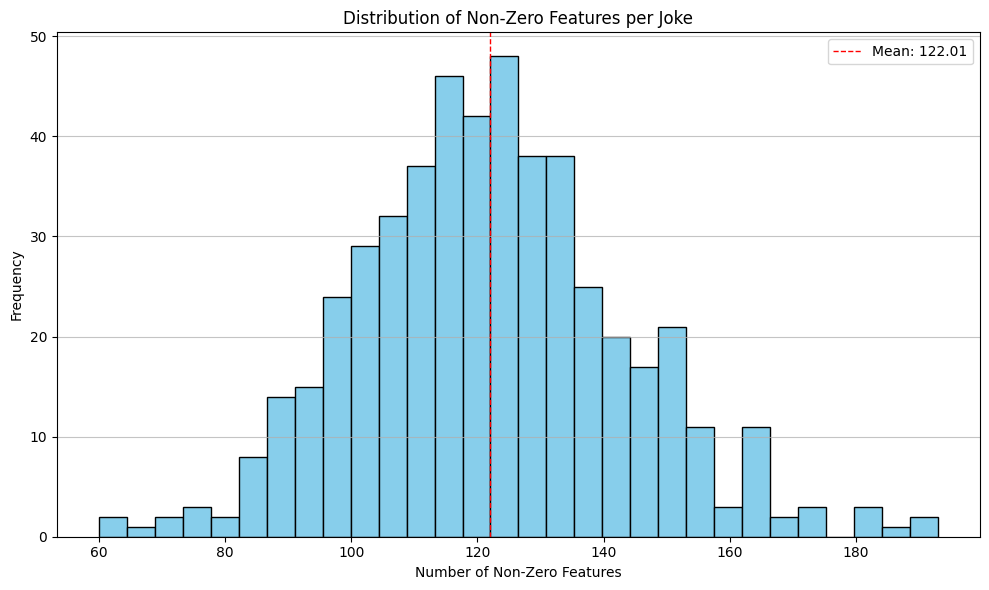

In [12]:
# Load the jokes dataset
jokes_df = pd.read_csv('shortjokes_500.csv')

# Initialize storage for non-zero feature indices
non_zero_indices = []

# Process each joke
for idx, row in tqdm(jokes_df.iterrows(), total=len(jokes_df), desc="Processing jokes"):
    joke = row['Joke']  # Get the joke from the 'Joke' column
    
    # Get activations from gemma-2-2b
    with gemma_2.trace(joke):
        l13_act_base = gemma_2.model.layers[13].output[0][:, -1].save()  # (1, 2304)
        gemma_2.model.layers[13].output.stop()
    
    # Get activations from gemma-2-2b-it
    with gemma_2_it.trace(joke):
        l13_act_it = gemma_2_it.model.layers[13].output[0][:, -1].save()  # (1, 2304)
        gemma_2_it.model.layers[13].output.stop()
    
    # Prepare input for crosscoder
    crosscoder_input = th.cat([l13_act_base, l13_act_it], dim=0).unsqueeze(0).cpu()  # (batch, 2, 2304)
    
    # Get reconstruction and features
    _, features = crosscoder(crosscoder_input, output_features=True)
    
    # Find indices of non-zero elements (> 1e-4)
    nonzero_mask = features.abs() > 1e-4
    nonzero_idx = nonzero_mask.nonzero().cpu().numpy()
    
    # Store the indices
    non_zero_indices.append([int(ni[1]) for ni in nonzero_idx])
    
    # Optional: Print progress info every 50 jokes
    if idx % 50 == 0 and idx > 0:
        print(f"Processed {idx} jokes. Latest non-zero count: {nonzero_mask.sum().item()}")


Saved non_zero_indices for 500 jokes to saved_data/non_zero_indices.pkl
Average non-zero elements per joke: 122.01
Min non-zero elements: 60
Max non-zero elements: 193
Number of unique feature indices activated across all jokes: 12239
Percentage of total features used: 16.60%


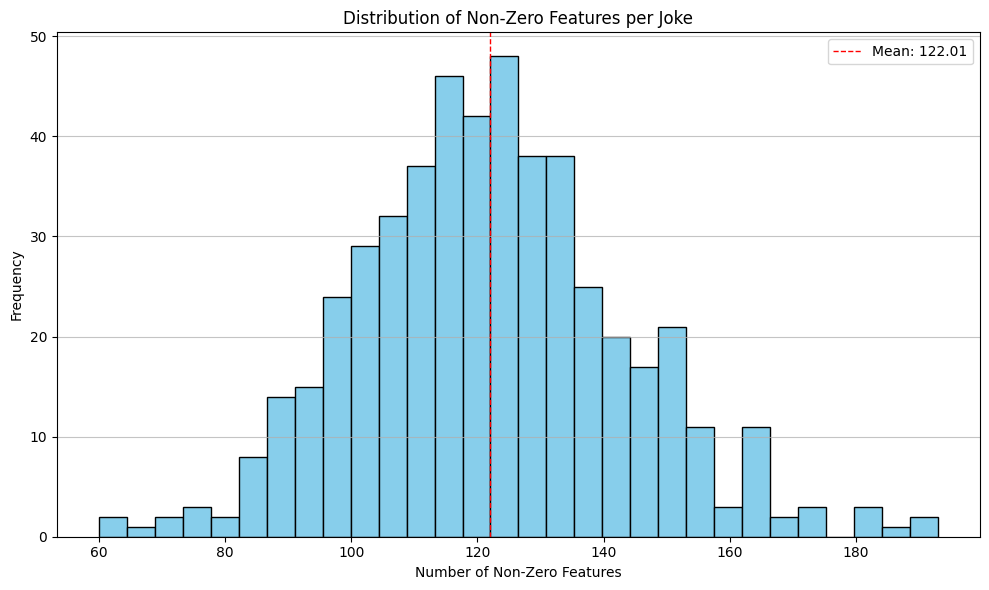

In [54]:
# Save non_zero_indices to a file for later use
import pickle
import os

# Create a directory for saved data if it doesn't exist
os.makedirs('saved_data', exist_ok=True)

# Save the non_zero_indices list using pickle
with open('non_zero_indices.pkl', 'wb') as f:
    pickle.dump(non_zero_indices, f)

print(f"Saved non_zero_indices for {len(non_zero_indices)} jokes to saved_data/non_zero_indices.pkl")

# Example of how to reload the data:
# with open('saved_data/non_zero_indices.pkl', 'rb') as f:
#     loaded_non_zero_indices = pickle.load(f)



# Summary statistics
total_nonzero_counts = [len(indices) for indices in non_zero_indices]
print(f"Average non-zero elements per joke: {np.mean(total_nonzero_counts):.2f}")
print(f"Min non-zero elements: {np.min(total_nonzero_counts)}")
print(f"Max non-zero elements: {np.max(total_nonzero_counts)}")
# Flatten all non-zero indices and count unique ones
all_indices = []
for indices in non_zero_indices:
    all_indices.extend(indices)
unique_indices = np.unique(all_indices)
print(f"Number of unique feature indices activated across all jokes: {len(unique_indices)}")
print(f"Percentage of total features used: {len(unique_indices) / features.shape[1] * 100:.2f}%")



# Create a histogram of non-zero feature counts
plt.figure(figsize=(10, 6))
plt.hist(total_nonzero_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Non-Zero Features per Joke')
plt.xlabel('Number of Non-Zero Features')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Add mean line
mean_count = np.mean(total_nonzero_counts)
plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=1, 
            label=f'Mean: {mean_count:.2f}')

plt.legend()
plt.tight_layout()
plt.show()




Number of features appearing in more than 5 jokes: 2226
Percentage of features appearing in more than 5 jokes: 18.19%


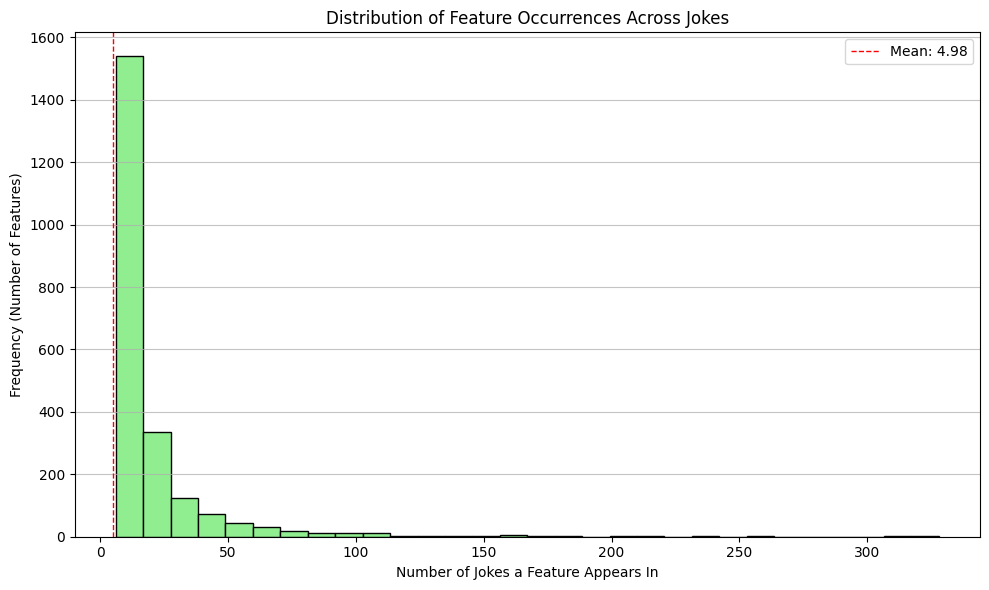

Total unique features found: 12239
Average number of jokes per feature: 4.98
Max number of jokes a feature appears in: 328


In [53]:
# Count how many jokes each feature appears in
feature_counts = {}
for joke_indices in non_zero_indices:
    for idx_val in joke_indices:
        if idx_val in feature_counts:
            feature_counts[idx_val] += 1
        else:
            feature_counts[idx_val] = 1

# Extract the counts for plotting
feature_occurrences = list(feature_counts.values())
# Filter features that appear in more than 5 jokes
filtered_feature_occurrences = [count for count in feature_occurrences if count > 5]
print(f"Number of features appearing in more than 5 jokes: {len(filtered_feature_occurrences)}")
print(f"Percentage of features appearing in more than 5 jokes: {len(filtered_feature_occurrences) / len(feature_occurrences) * 100:.2f}%")

# Create a histogram of feature occurrences
plt.figure(figsize=(10, 6))
plt.hist(filtered_feature_occurrences, bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Feature Occurrences Across Jokes')
plt.xlabel('Number of Jokes a Feature Appears In')
plt.ylabel('Frequency (Number of Features)')
plt.grid(axis='y', alpha=0.75)

# Add mean line
mean_occurrence = np.mean(feature_occurrences)
plt.axvline(mean_occurrence, color='red', linestyle='dashed', linewidth=1, 
            label=f'Mean: {mean_occurrence:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Total unique features found: {len(feature_counts)}")
print(f"Average number of jokes per feature: {mean_occurrence:.2f}")
print(f"Max number of jokes a feature appears in: {max(feature_occurrences)}")
